In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import time
import re
%matplotlib inline
pd.set_option("display.max_rows",25)
pd.set_option("display.max_columns",15)
pd.options.display.float_format = "{:.2f}".format

** DATA PROCESSING**  

In [2]:
#Importing files picked after Web scraping

df_14=pd.read_pickle("df_2701_02.pkl")
df_15=pd.read_pickle("df_2701_2015.pkl")
df_16=pd.read_pickle("df_2701_2016.pkl")
df_17=pd.read_pickle("df_2701_2017.pkl")


In [3]:
#Concatenating to a final dataframe fo all year

df_list=[df_14,df_15,df_16,df_17]
df=pd.concat(df_list,ignore_index=True)

In [4]:
# dropping value with least number of non-null object
df.columns=df.columns.str.lower()
df.drop(["content_rating","cumm_rev","cast","movie"],inplace=True,axis=1)

In [5]:
#converting string data to numeric
df["reviews"]=df.reviews.str.replace(",","").str.strip()
df.reviews.dropna(inplace=True,how=any)
df.reviews=df.reviews.apply(lambda x: int(x))
df.reviews.dropna(inplace=True,how=any)

df.run_time=df.run_time.str.replace(",","").str.strip()
df.run_time.dropna(inplace=True,how='any')
df.run_time=df.run_time.apply(lambda x: float(x))
df.run_time.dropna(inplace=True,how='any')

df.rating=df.rating.str.replace(",","").str.strip()
df.rating.dropna(inplace=True,how='any')
df.rating=df.rating.apply(lambda x: float(x))
df.rating.dropna(inplace=True,how='any')

# convesion $ to to numeric
x=df.budget.str.startswith("$")==True
df.budget[x]=df.budget[x].str.replace("$","").str.replace(",","")
bd=[]
for i in df.budget:
    
    try:
        i=i.replace(",","")
        #print(i)
        bd.append(int(i))
    except:
        bd.append(0.0)
    
budget=pd.Series(bd)
df.budget=budget

C:\Users\varru\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
#dropping all ZEROs
df.budget=df.budget[df.budget!=0.0]
df.budget.dropna(inplace=True,how="any")
df.gross_rev=df.gross_rev.str.replace(",","").str.strip()

#converting string to Integer type
df.gross_rev.dropna(inplace=True)
df.gross_rev=df.gross_rev.apply(int)

In [7]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 0 to 30455
Data columns (total 11 columns):
budget          777 non-null float64
country         777 non-null object
director        777 non-null object
genre           777 non-null object
gross_rev       777 non-null float64
language        777 non-null object
plot            777 non-null object
rating          777 non-null float64
release_date    777 non-null object
reviews         777 non-null float64
run_time        777 non-null float64
dtypes: float64(5), object(6)
memory usage: 72.8+ KB


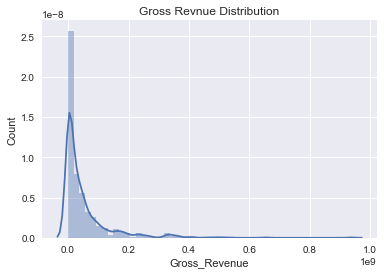

In [8]:
import seaborn as sns
plt.ylabel("Count")
plt.title("Gross Revnue Distribution")
sns.distplot(df.gross_rev);
plt.xlabel("Gross_Revenue")


In [9]:
#Converting Release date as time stamp

df["release_date"].dropna(inplace=True)
df.release_date=pd.to_datetime(df.release_date)
import datetime
df["timestamp"]=[datetime.datetime.timestamp(i) for i in df.release_date]
df.drop("release_date",inplace=True,axis=1)

In [10]:
df.corr() # Correlation Matrix

,budget,gross_rev,rating,reviews,run_time,timestamp
budget,1.00,0.72,0.21,0.58,0.39,0.03
gross_rev,0.72,1.00,0.29,0.68,0.27,0.00
rating,0.21,0.29,1.00,0.46,0.43,0.04
reviews,0.58,0.68,0.46,1.00,0.42,-0.17
run_time,0.39,0.27,0.43,0.42,1.00,0.04
timestamp,0.03,0.00,0.04,-0.17,0.04,1.00


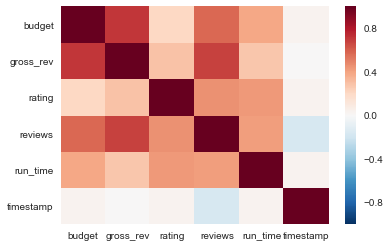

In [11]:
sns.heatmap(df.corr())

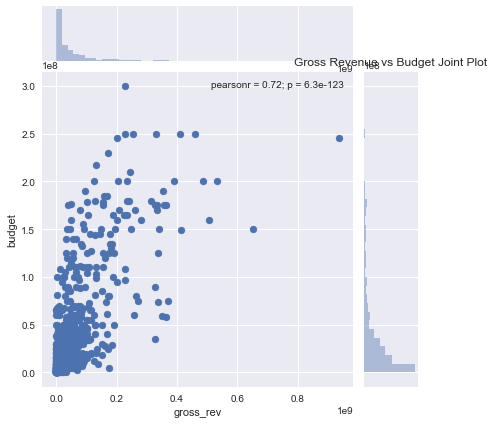

In [12]:
sns.jointplot("gross_rev","budget",data=df)
plt.title("Gross Revenue vs Budget Joint Plot")

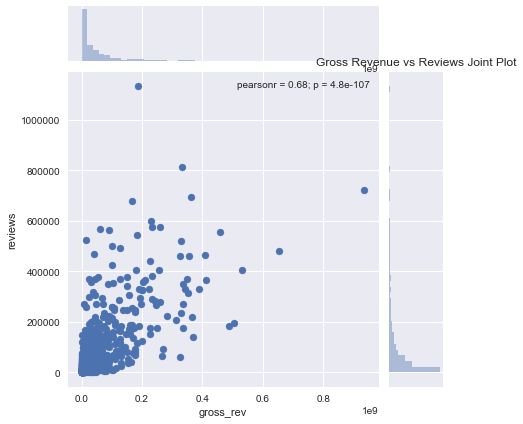

In [13]:
sns.jointplot("gross_rev","reviews",data=df)
plt.title("Gross Revenue vs Reviews Joint Plot")

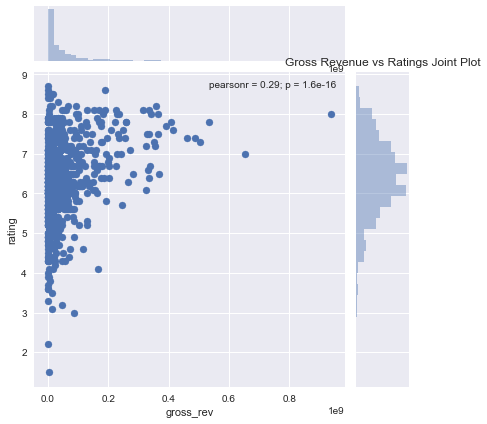

In [14]:
sns.jointplot("gross_rev","rating",data=df)
plt.title("Gross Revenue vs Ratings Joint Plot")

In [15]:
#For running NLP
df.plot=df["plot"].str.replace("\n","").str.strip()
df_plot=df["plot"]
df.drop("plot",axis=1,inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 0 to 30455
Data columns (total 10 columns):
budget       777 non-null float64
country      777 non-null object
director     777 non-null object
genre        777 non-null object
gross_rev    777 non-null float64
language     777 non-null object
rating       777 non-null float64
reviews      777 non-null float64
run_time     777 non-null float64
timestamp    777 non-null float64
dtypes: float64(6), object(4)
memory usage: 86.8+ KB


In [17]:
dummy=df.copy()

In [18]:
#Converting Genre in features
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
dummy = dummy.join(pd.DataFrame(mlb.fit_transform(dummy.pop('genre')),
                          columns=mlb.classes_,
                          index=dummy.index),)


In [19]:
#get dummies for country
dummy_country=pd.get_dummies(dummy.country)
dummy=dummy.join(dummy_country)
dummy.drop("country",inplace=True,axis=1)
#dummy.drop("index",axis=1,inplace=True)
#dummy.drop(["director","rating","Biography","Comedy","Crime","Drama","History","Horror","Music","Music","Musical","Mystery","News","Sport","Thriller","War","Western","Argentina","Canada"]
#           ,inplace=True,axis=1)

**MACHINE LEARNING**

In [20]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from sklearn.feature_selection import chi2,SelectKBest
from sklearn.preprocessing import LabelEncoder

C:\Users\varru\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [21]:
target=dummy["gross_rev"]
feature=dummy.drop(["gross_rev"],axis=1)

#converting categorical data into numeric
label_encode=LabelEncoder()

language_encode=label_encode.fit_transform(feature.language)
director_encode=label_encode.fit_transform(feature.director)

feature.director=director_encode.reshape(len(director_encode),1)
feature.language=language_encode.reshape(len(language_encode),1)



In [22]:
dummy.corr()


,budget,gross_rev,rating,reviews,run_time,timestamp,Action,...,Spain,Sweden,Taiwan,Thailand,UK,USA,United Arab Emirates
budget,1.00,0.72,0.21,0.58,0.39,0.03,0.45,...,-0.02,-0.02,-0.02,-0.02,0.01,0.03,-0.02
gross_rev,0.72,1.00,0.29,0.68,0.27,0.00,0.28,...,-0.02,-0.02,-0.02,-0.03,-0.04,0.10,-0.01
rating,0.21,0.29,1.00,0.46,0.43,0.04,-0.03,...,-0.04,0.02,-0.00,-0.04,0.12,-0.12,-0.04
reviews,0.58,0.68,0.46,1.00,0.42,-0.17,0.27,...,-0.02,-0.02,-0.02,-0.03,0.04,0.05,-0.01
run_time,0.39,0.27,0.43,0.42,1.00,0.04,0.19,...,0.01,-0.01,-0.01,-0.02,0.05,-0.16,0.00
timestamp,0.03,0.00,0.04,-0.17,0.04,1.00,0.01,...,-0.03,0.05,-0.01,0.03,0.04,-0.10,0.04
Action,0.45,0.28,-0.03,0.27,0.19,0.01,1.00,...,-0.02,-0.02,0.06,0.02,-0.01,-0.11,-0.02
Adventure,0.62,0.43,0.09,0.32,0.14,0.04,0.34,...,-0.02,-0.02,-0.02,-0.03,-0.03,-0.02,-0.02
Animation,0.20,0.20,0.07,-0.02,-0.24,0.06,-0.03,...,-0.01,-0.01,-0.01,-0.01,-0.05,-0.02,-0.01
Biography,-0.13,-0.09,0.19,-0.07,0.17,0.03,-0.15,...,-0.01,-0.01,-0.01,-0.02,0.18,-0.12,-0.01


** Baselining **  


In [23]:
def model_plots(y_pred,target):
    import scipy.stats as stats
    #Residual Plot
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    sns.regplot(y_pred,target-y_pred,dropna=True)
    plt.title("Residual Plot")
    plt.xlabel('Predicted Value')
    plt.ylabel('Residual')

    #Q-Q plot
    plt.subplot(1,2,2)
    stats.probplot(target-y_pred, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    plt.show()

    #Y_Actual to Y_Predict
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    plt.title("Gross Revneues_observed Vs Gross Revneues_Predicted")
    
    sns.regplot(y_pred,target)
    plt.xlabel("Y_predict")
    plt.show()


In [24]:
# REVIEWS and Gross_revenues
model1=sm.OLS(target,feature.reviews)
results1 = model1.fit()
results1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              gross_rev   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     1145.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):          6.79e-155
Time:                        21:44:39   Log-Likelihood:                -15081.
No. Observations:                 777   AIC:                         3.016e+04
Df Residuals:                     776   BIC:                         3.017e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
reviews      528.9017     15.631     33.837      0.000     498.218     559.585
==============================================================================
Omnibus:                      399.493   Durbin-Watson:                   1.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9185.499
Skew:                           1.805   Prob(JB):                         0.00
Kurtosis:                      19.452   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

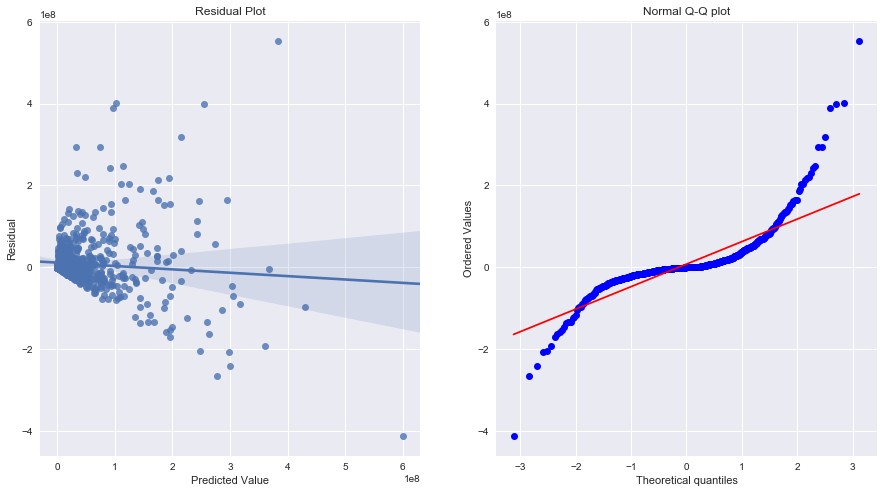

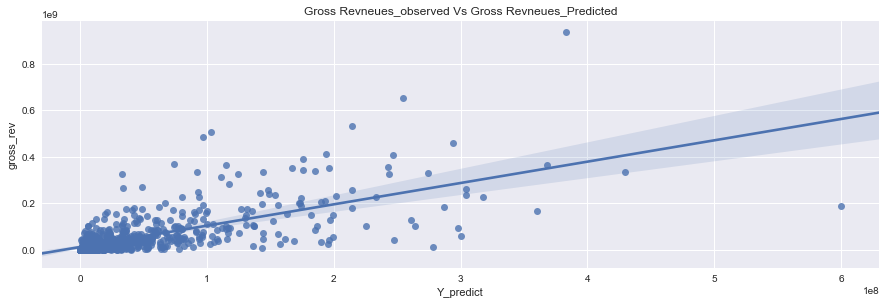

In [25]:
y_pred = results1.predict(feature.reviews)
model_plots(y_pred,target)


In [26]:
# Rating and Gross_revenues
model2=sm.OLS(target,feature.budget)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              gross_rev   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     1377.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):          4.30e-174
Time:                        21:44:41   Log-Likelihood:                -15036.
No. Observations:                 777   AIC:                         3.007e+04
Df Residuals:                     776   BIC:                         3.008e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
budget         1.2493      0.034     37.102      0.000       1.183       1.315
==============================================================================
Omnibus:                      567.345   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16466.596
Skew:                           2.929   Prob(JB):                         0.00
Kurtosis:                      24.779   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

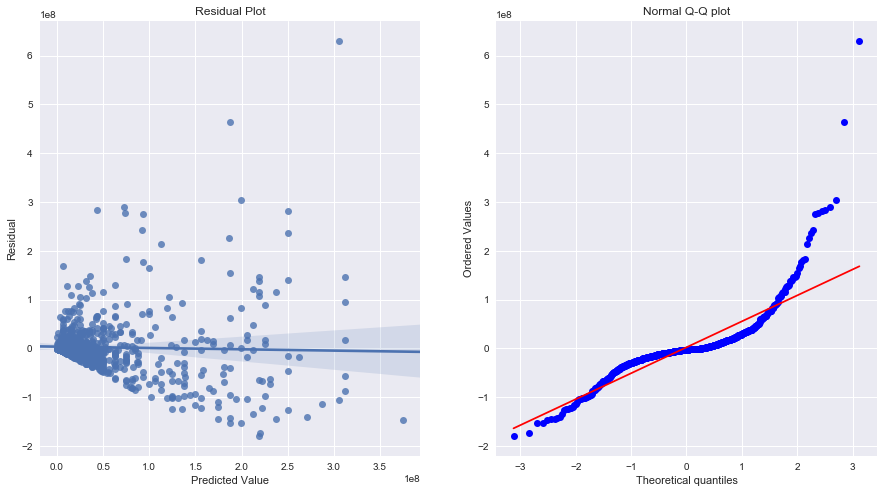

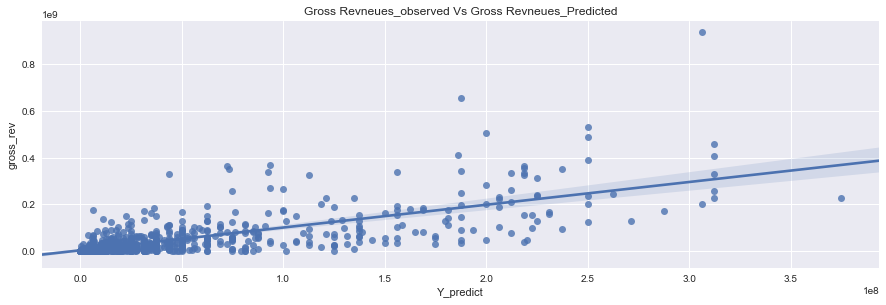

In [27]:
y_pred = results2.predict(feature.budget)
model_plots(y_pred,target)

In [28]:
# Run_time and gross_revenues
model3=sm.OLS(target,feature.run_time)
results3 = model3.fit()
results3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              gross_rev   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     323.6
Date:                Fri, 02 Feb 2018   Prob (F-statistic):           9.73e-61
Time:                        21:44:42   Log-Likelihood:                -15297.
No. Observations:                 777   AIC:                         3.060e+04
Df Residuals:                     776   BIC:                         3.060e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
run_time    5.032e+05    2.8e+04     17.989      0.000    4.48e+05    5.58e+05
==============================================================================
Omnibus:                      652.253   Durbin-Watson:                   1.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16299.514
Skew:                           3.716   Prob(JB):                         0.00
Kurtosis:                      24.172   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

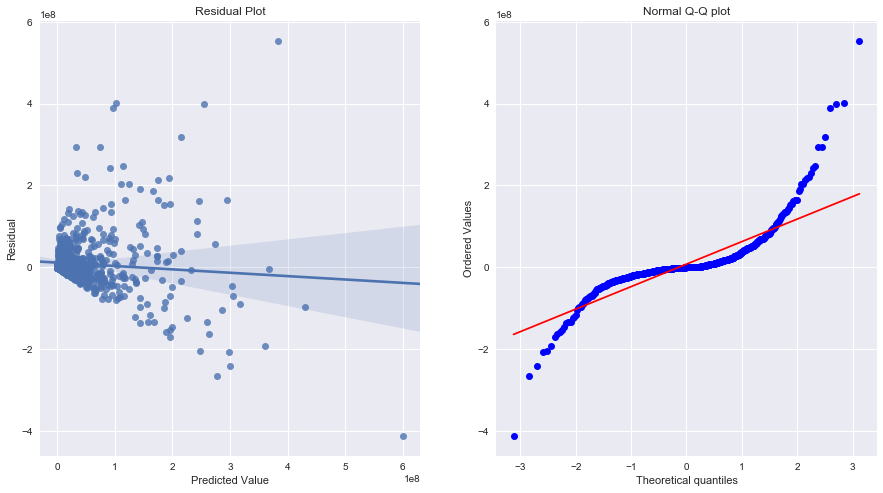

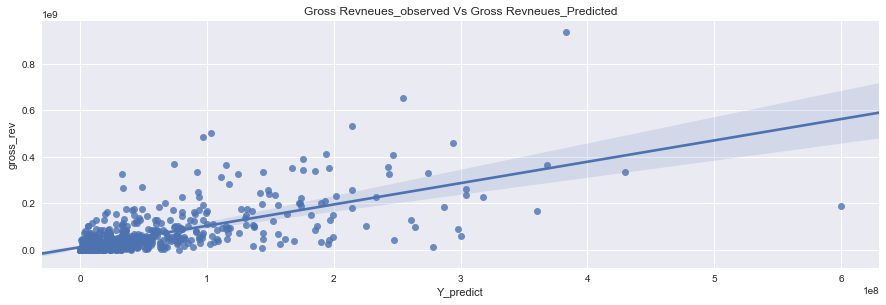

In [29]:
y_pred = results3.predict(feature.run_time)
y_pred = results1.predict(feature.reviews)
model_plots(y_pred,target)


In [30]:
# Adventure Genre and Gross_revenue
model4=sm.OLS(target,feature.Adventure)
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              gross_rev   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     377.1
Date:                Fri, 02 Feb 2018   Prob (F-statistic):           9.14e-69
Time:                        21:44:44   Log-Likelihood:                -15279.
No. Observations:                 777   AIC:                         3.056e+04
Df Residuals:                     776   BIC:                         3.056e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Adventure   1.212e+08   6.24e+06     19.419      0.000    1.09e+08    1.33e+08
==============================================================================
Omnibus:                      515.847   Durbin-Watson:                   1.497
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10713.922
Skew:                           2.660   Prob(JB):                         0.00
Kurtosis:                      20.396   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

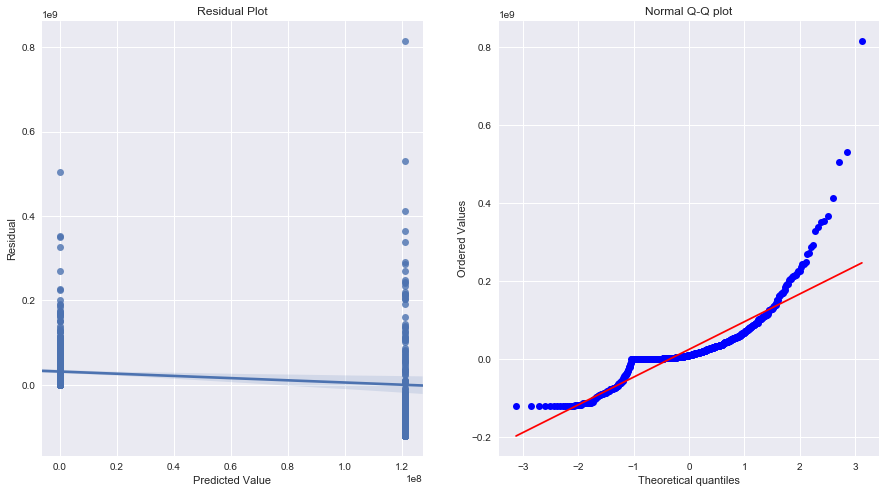

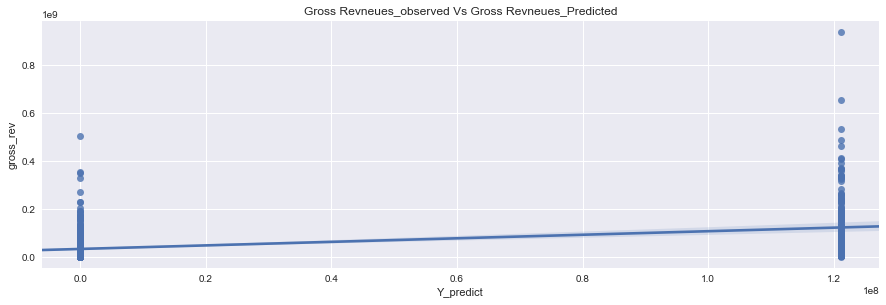

In [31]:
y_pred = results4.predict(feature.Adventure)
model_plots(y_pred,target)


# Statsmodel on Medium Complexity

In [32]:
model_medium_complex = smf.ols('gross_rev ~ reviews + budget + Action + Adventure', data=dummy)
result_Mcomplex=model_medium_complex.fit()
result_Mcomplex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              gross_rev   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     318.1
Date:                Fri, 02 Feb 2018   Prob (F-statistic):          1.36e-161
Time:                        21:44:45   Log-Likelihood:                -14936.
No. Observations:                 777   AIC:                         2.988e+04
Df Residuals:                     772   BIC:                         2.991e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -3.29e+06    2.6e+06     -1.265      0.206   -8.39e+06    1.81e+06
reviews      286.9826     19.341     14.838      0.000     249.015     324.950
budget         0.8549      0.058     14.744      0.000       0.741       0.969
Action     -1.119e+07   4.83e+06     -2.317      0.021   -2.07e+07   -1.71e+06
Adventure    1.83e+06    5.9e+06      0.310      0.757   -9.76e+06    1.34e+07
==============================================================================
Omnibus:                      547.943   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15778.456
Skew:                           2.780   Prob(JB):                         0.00
Kurtosis:                      24.365   Cond. No.                     2.01e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

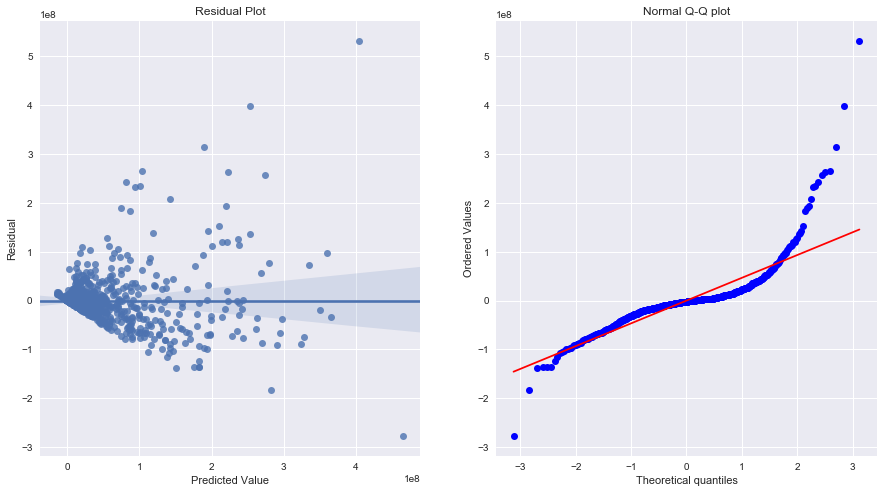

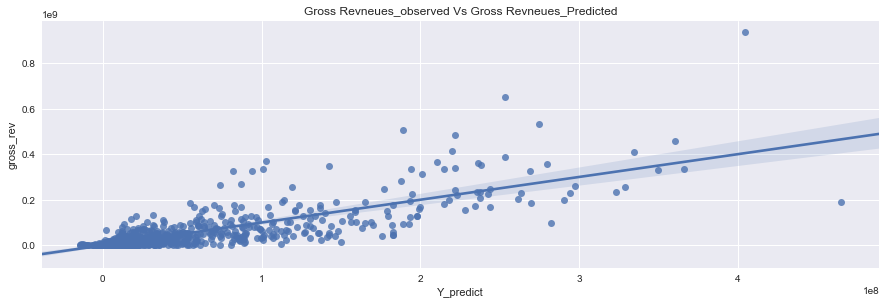

In [33]:
mini_feature=pd.concat([feature["reviews"],feature["budget"],feature["Action"],feature["Adventure"]],axis=1)
y_pred = result_Mcomplex.predict(mini_feature)
model_plots(y_pred,target)


# Statsmodel on all features  (MULTIPLE LINEAR REGRESSION)

In [34]:
model = sm.OLS(target,feature)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              gross_rev   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     23.73
Date:                Fri, 02 Feb 2018   Prob (F-statistic):          1.05e-137
Time:                        21:44:47   Log-Likelihood:                -14866.
No. Observations:                 777   AIC:                         2.986e+04
Df Residuals:                     711   BIC:                         3.017e+04
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
budget                   0.8214      0.066     12.439      0.000       0.692       0.951
director             -1180.9975   1.02e+04     -0.116      0.908   -2.12e+04    1.89e+04
language              1.661e+05   1.15e+06      0.145      0.885   -2.08e+06    2.42e+06
rating                2.753e+06   2.53e+06      1.087      0.277   -2.22e+06    7.72e+06
reviews                317.0998     23.769     13.341      0.000     270.435     363.765
run_time             -2.154e+05   1.67e+05     -1.287      0.199   -5.44e+05    1.13e+05
timestamp                0.1916      0.059      3.246      0.001       0.076       0.308
Action                1.807e+06   5.65e+06      0.320      0.749   -9.29e+06    1.29e+07
Adventure            -1.185e+07   6.65e+06     -1.783      0.075   -2.49e+07     1.2e+06
Animation             1.129e+07   1.08e+07      1.044      0.297   -9.94e+06    3.25e+07
Biography             8.303e+06   7.55e+06      1.100      0.272   -6.52e+06    2.31e+07
Comedy                 8.27e+05   5.37e+06      0.154      0.878   -9.71e+06    1.14e+07
Crime                -7.595e+06   6.16e+06     -1.234      0.218   -1.97e+07    4.49e+06
Drama                -1.579e+07   5.17e+06     -3.054      0.002   -2.59e+07   -5.64e+06
Family                2.407e+07    8.8e+06      2.737      0.006     6.8e+06    4.13e+07
Fantasy              -9.584e+06   6.68e+06     -1.435      0.152   -2.27e+07    3.53e+06
History                2.21e+06   9.83e+06      0.225      0.822   -1.71e+07    2.15e+07
Horror                 6.06e+06   7.13e+06      0.850      0.396   -7.94e+06    2.01e+07
Music                 8.249e+06   1.07e+07      0.770      0.442   -1.28e+07    2.93e+07
Musical               3.125e+07   1.47e+07      2.123      0.034    2.35e+06    6.02e+07
Mystery               -2.01e+06   6.24e+06     -0.322      0.748   -1.43e+07    1.02e+07
Romance               5.623e+06   5.65e+06      0.996      0.320   -5.46e+06    1.67e+07
Sci-Fi               -7.077e+06    6.7e+06     -1.057      0.291   -2.02e+07    6.07e+06
Sport                -4.147e+06    1.2e+07     -0.345      0.730   -2.78e+07    1.95e+07
Thriller             -5.779e+06   5.74e+06     -1.007      0.314    -1.7e+07    5.48e+06
War                   1.956e+06   1.04e+07      0.188      0.851   -1.85e+07    2.24e+07
Western              -2.655e+07   1.67e+07     -1.589      0.112   -5.94e+07    6.25e+06
Argentina            -2.871e+08      1e+08     -2.866      0.004   -4.84e+08   -9.04e+07
Australia            -2.688e+08   8.64e+07     -3.110      0.002   -4.38e+08   -9.91e+07
Belgium              -2.945e+08   9.31e+07     -3.163      0.002   -4.77e+08   -1.12e+08
Brazil               -2.623e+08   9.96e+07     -2.634      0.009   -4.58e+08   -6.68e+07
Canada               -2.652e+08   8.69e+07     -3.052    

** Dropping High P-Values Features**  




In [35]:
drop_cols=["director","rating","Biography","Crime","Drama","History","Music","Musical","Mystery","Romance","Sport","Thriller","War","Western","Horror"]
feature.drop(drop_cols,inplace=True,axis=1)

In [36]:
model = sm.OLS(target,feature)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              gross_rev   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     29.71
Date:                Fri, 02 Feb 2018   Prob (F-statistic):          1.81e-142
Time:                        21:44:47   Log-Likelihood:                -14882.
No. Observations:                 777   AIC:                         2.987e+04
Df Residuals:                     726   BIC:                         3.010e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
budget                   0.8579      0.064     13.345      0.000       0.732       0.984
language              1.702e+05   1.15e+06      0.148      0.882   -2.08e+06    2.42e+06
reviews                323.3499     21.241     15.223      0.000     281.648     365.052
run_time             -2.808e+05    1.5e+05     -1.871      0.062   -5.75e+05    1.38e+04
timestamp                0.1847      0.058      3.175      0.002       0.070       0.299
Action               -6.903e+05   5.19e+06     -0.133      0.894   -1.09e+07     9.5e+06
Adventure            -1.051e+07   6.52e+06     -1.613      0.107   -2.33e+07    2.28e+06
Animation              1.11e+07   1.06e+07      1.046      0.296   -9.75e+06     3.2e+07
Comedy                7.219e+06   4.51e+06      1.602      0.110   -1.63e+06    1.61e+07
Family                2.724e+07   8.67e+06      3.142      0.002    1.02e+07    4.43e+07
Fantasy              -6.961e+06   6.51e+06     -1.070      0.285   -1.97e+07    5.81e+06
Sci-Fi                -5.55e+06   6.53e+06     -0.849      0.396   -1.84e+07    7.28e+06
Argentina            -2.761e+08   9.99e+07     -2.763      0.006   -4.72e+08   -7.99e+07
Australia            -2.458e+08   8.64e+07     -2.846      0.005   -4.15e+08   -7.63e+07
Belgium              -2.696e+08   9.22e+07     -2.924      0.004   -4.51e+08   -8.86e+07
Brazil               -2.397e+08    9.9e+07     -2.420      0.016   -4.34e+08   -4.53e+07
Canada                -2.45e+08   8.64e+07     -2.835      0.005   -4.15e+08   -7.53e+07
Chile                -2.547e+08    9.3e+07     -2.739      0.006   -4.37e+08   -7.21e+07
China                -2.807e+08   8.62e+07     -3.257      0.001    -4.5e+08   -1.11e+08
Colombia             -2.264e+08   1.01e+08     -2.251      0.025   -4.24e+08   -2.89e+07
Czech Republic       -2.637e+08   8.92e+07     -2.956      0.003   -4.39e+08   -8.86e+07
Denmark              -2.626e+08      1e+08     -2.617      0.009    -4.6e+08   -6.56e+07
Finland              -2.531e+08      1e+08     -2.519      0.012    -4.5e+08   -5.58e+07
France               -2.618e+08   8.57e+07     -3.054      0.002    -4.3e+08   -9.35e+07
Germany              -2.574e+08   9.51e+07     -2.706      0.007   -4.44e+08   -7.06e+07
Hong Kong            -2.267e+08   8.86e+07     -2.558      0.011   -4.01e+08   -5.27e+07
India                -2.429e+08    8.8e+07     -2.760      0.006   -4.16e+08   -7.01e+07
Indonesia            -2.486e+08   9.84e+07     -2.526      0.012   -4.42e+08   -5.54e+07
Ireland              -2.693e+08   8.91e+07     -3.023      0.003   -4.44e+08   -9.44e+07
Israel               -2.495e+08      1e+08     -2.490      0.013   -4.46e+08   -5.28e+07
Japan                -1.462e+08   8.83e+07     -1.656      0.098    -3.2e+08    2.71e+07
Kenya                -2.531e+08   9.75e+07     -2.595    

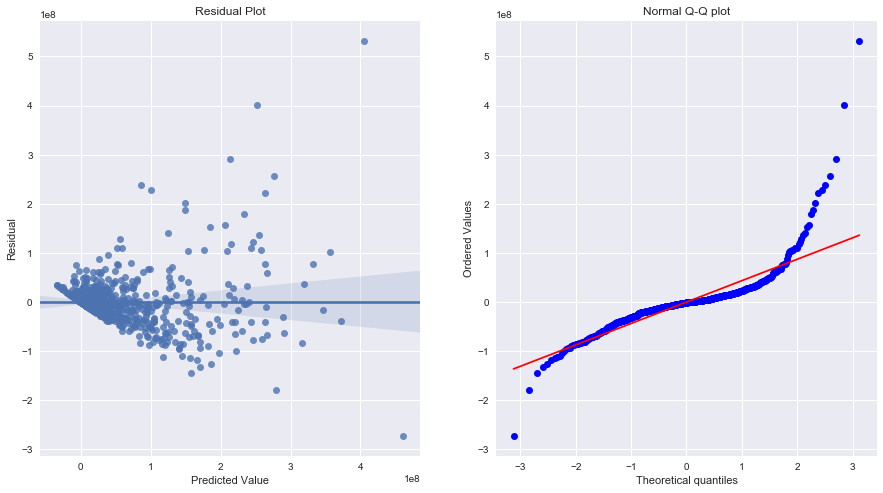

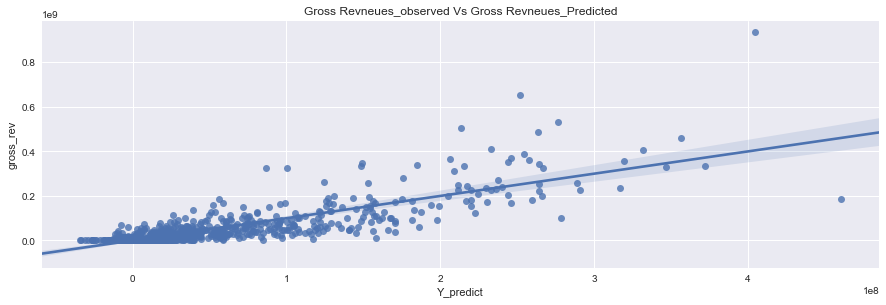

In [37]:
y_pred = results.predict(feature)
model_plots(y_pred,target)

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split

#Splitting the Data for a 20% heldout test set
X_train, X_test, y_train, y_test=train_test_split(feature,target,test_size=0.2,)


In [39]:
#Using stand scaler for scaling as preprocessing

scaler=MinMaxScaler()
X_train_scaled=np.array(scaler.fit_transform((X_train)))
X_test_scaled=np.array(scaler.transform((X_test)))
X_train=np.array(X_train_scaled)
y_train=np.array(y_train)

** Linear Regression with cross validation **  

In [40]:
kf=KFold(n_splits=5,random_state=30,shuffle=True)
from sklearn.linear_model import Ridge, Lasso
cv_lm=[]
cv_lm_rg=[]
cv_lm_lasso=[]
for train_ind, val_ind in kf.split((X_train_scaled),(y_train)):
    
    lm=LinearRegression()
    lm_ridge=Ridge(alpha=100)
    lm_lasso=Lasso(alpha=10000)
    
    X,y=X_train_scaled[train_ind],y_train[train_ind]
    X_val,y_val=X_train_scaled[val_ind],y_train[val_ind]
    
    lm.fit(X,y)
    lm_ridge.fit(X,y)
    lm_lasso.fit(X,y)
    
    cv_lm.append(lm.score(X_val,y_val))
    cv_lm_rg.append(lm_ridge.score(X_val,y_val))
    cv_lm_lasso.append(lm_lasso.score(X_val,y_val))

In [41]:
print("Score for cross validation using Linear Regression",pd.Series(cv_lm).mean())

Score for cross validation using Linear Regression -5.875412549833024e+22


In [42]:
print("Score on TEST set using Linear Regression",lm.score(X_test_scaled,y_test))

Score on TEST set using Linear Regression -8.46116642409e+23


In [43]:
#Scores of Cross validation Linear Regression 
cv_lm

[-2.2732807218785231e+21,
 -8.125814491742882e+22,
 0.61315590225733674,
 -1.0089631079539138e+22,
 -2.001495707728047e+23]

In [44]:
from sklearn.metrics import mean_squared_error

def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted))

In [45]:
#coefficients of  Lasso Regression with 5 fold CV without grid search
#list(zip(X_test_scaled.columns,lm_lasso.coef_))

In [46]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline


alpha_list_lasso=np.linspace(30000,1000000,100)
alpha_list_ridge=np.linspace(0.01,10000,1000)
params1={'alpha':alpha_list_lasso}
params2={'alpha':alpha_list_ridge}
kf=KFold(n_splits=10,random_state=30,shuffle=True)

def best_grid(model,alpha,params,cv):
    grid=GridSearchCV(model,param_grid=params,cv=cv)
    grid.fit(X_train_scaled,y_train
            )
    return grid

C:\Users\varru\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\varru\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


** Lasso Regularization **

In [47]:
lasso=best_grid(Lasso(),alpha_list_lasso,params1,kf.n_splits)

In [48]:
y_predict_lass=lasso.predict(X_test_scaled)
print("Best Score CV Lasso Regularization Grid search :",lasso.best_score_)
print("Best parameters CV Lasso regularization Grid Search :",lasso.best_params_)
print("Score on test set Lasso :",lasso.score(X_test_scaled,y_test))

Best Score CV Lasso Regularization Grid search : 0.5826223148766634
Best parameters CV Lasso regularization Grid Search : {'alpha': 363131.31313131313}
Score on test set Lasso : 0.727784054385


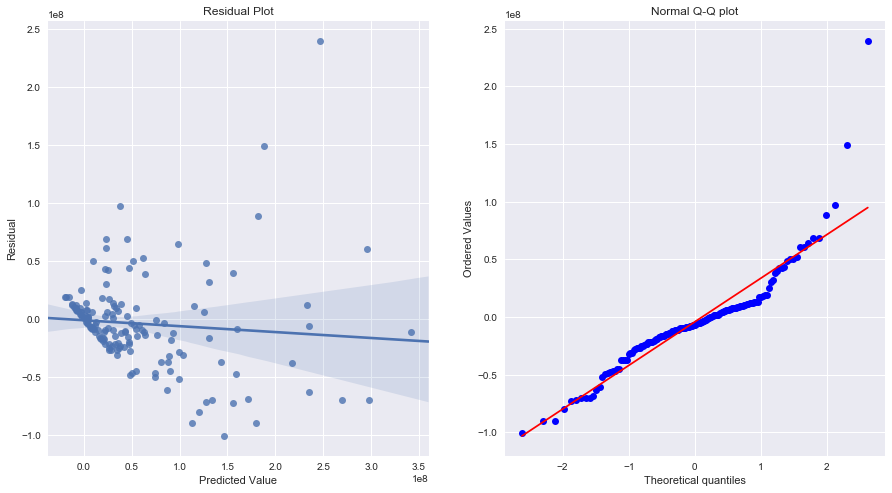

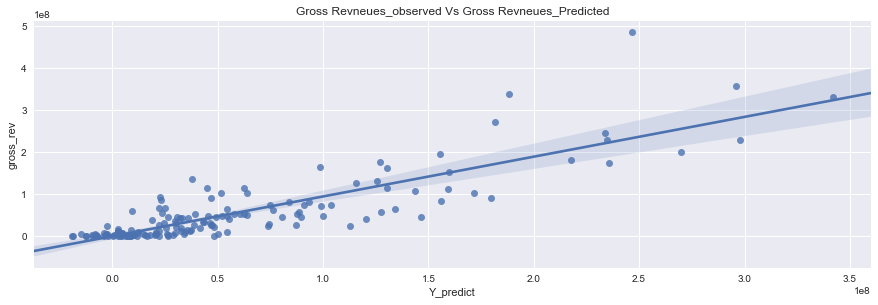

In [49]:
model_plots(y_predict_lass,y_test)

** Ridge Regularization**  

In [50]:
#Ridge
ridge=best_grid(Ridge(),alpha_list_ridge,params2,kf.n_splits)
print("Best Score CV Ridge Regularization Grid search :",ridge.best_score_)
print("Best parameters CV Ridge regularization Grid Search :",ridge.best_params_)
print("Score on test set Ridge :",ridge.score(X_test_scaled,y_test))

Best Score CV Ridge Regularization Grid search : 0.5551375353844527
Best parameters CV Ridge regularization Grid Search : {'alpha': 0.01}
Score on test set Ridge : 0.723285321177


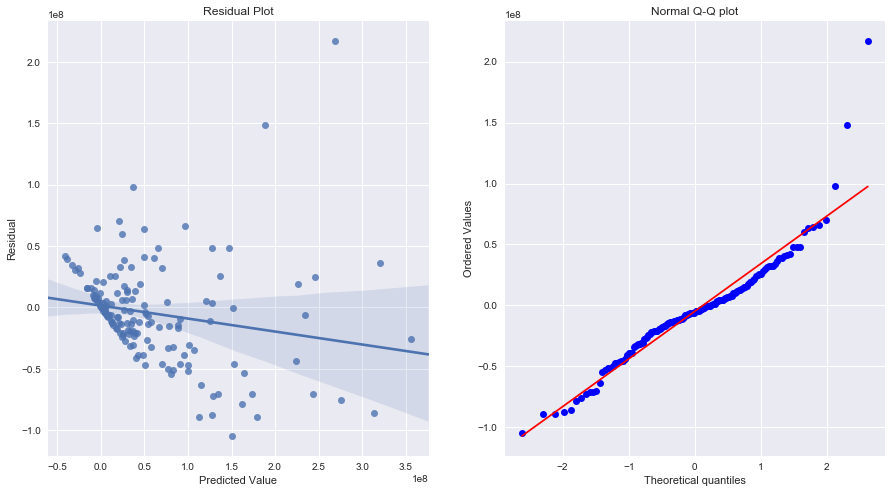

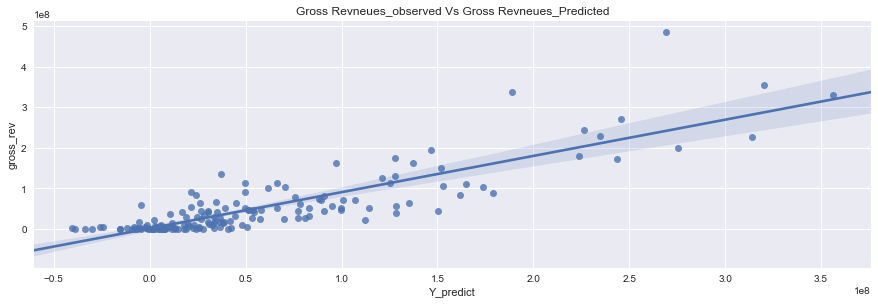

In [51]:
y_predict_ridge=ridge.predict(X_test_scaled)
model_plots(y_predict_ridge,y_test)

** Introducing Polynomial Features and Regularization **

In [52]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
# Set the degree of our polynomial
degree=2

est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=890000))
est.fit(X_train_scaled, y_train)
poly_test_score=est.score(X_test_scaled,y_test)
print("Score Test Grid search :",poly_test_score)



Score Test Grid search : 0.681860129703


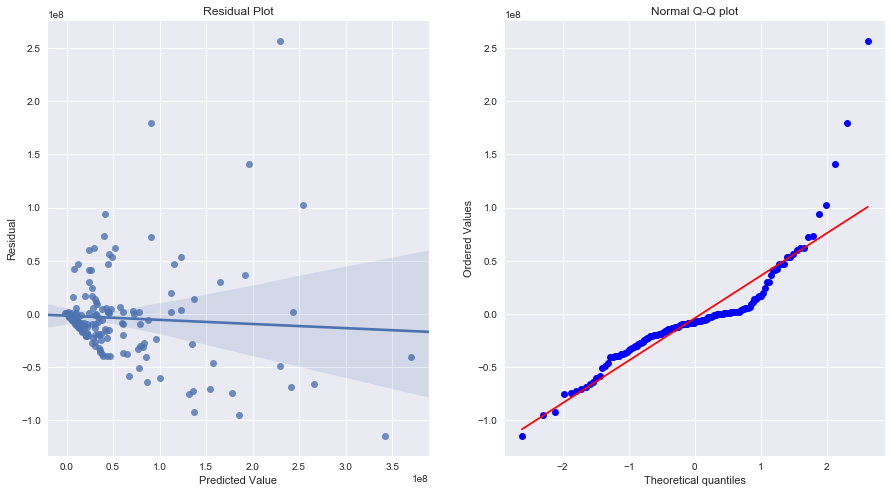

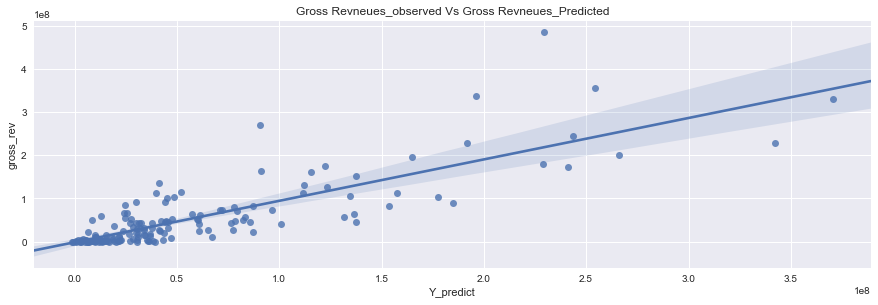

In [53]:
y_predict_poly=est.predict(X_test_scaled)
model_plots(y_predict_poly,y_test)


In [54]:
from sklearn.pipeline import Pipeline

alphalist = np.linspace(10000,500000,2000)
err_vec_test = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    steps = [('standardize', MinMaxScaler()), ('lasso', Lasso(alpha = curr_alpha))]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    test_set_pred7 = pipe.predict(X_test)
    err_vec_test[i] = np.sqrt(np.mean((test_set_pred7 - y_test)**2))

    train_set_pred7 = pipe.predict(X_train)
    err_vec_train[i] = np.sqrt(np.mean((train_set_pred7 - y_train)**2))

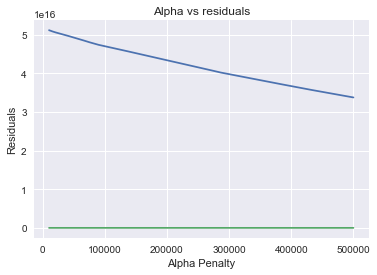

In [55]:
plt.title("Alpha vs residuals")
plt.xlabel("Alpha Penalty")
plt.ylabel("Residuals")
plt.plot((alphalist),err_vec_test)
plt.plot((alphalist),err_vec_train)

Computing regularization path using the LARS ...
.

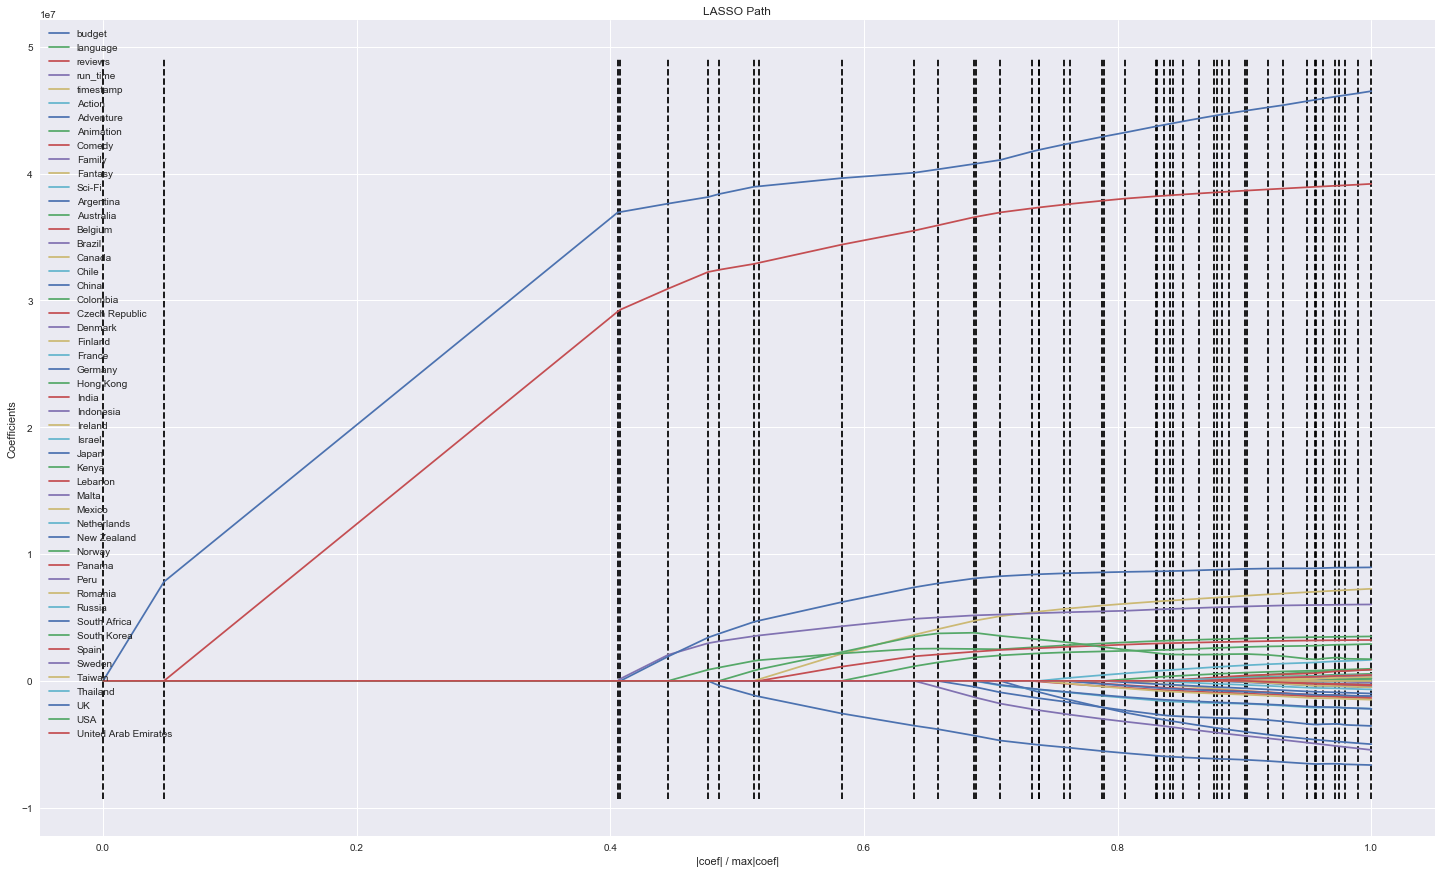

In [59]:
from sklearn.linear_model import lars_path

## Scale the variables
std = StandardScaler()
#std.fit(X_train.values.astype(float))
std.fit(X_train)
X_tr = std.transform(X_train)
feature_columns=feature.columns


## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train, method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(25,15))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(feature_columns)
plt.show()



In [58]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

X_train_c, X_test_c, y_train_c, y_test_c=train_test_split(feature,target,test_size=0.2,)


rf = RandomForestRegressor(n_estimators=2000, max_features=3, max_depth=5)
rf.fit(X_train_c, y_train_c)
y_pred_c = rf.predict(X_test_c)
print("Random Forest Regression:", r2_score(y_test_c, y_pred_c))

gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=1)
gbm.fit(X_train_c, y_train_c)
y_pred_grad = gbm.predict(X_test_c)
print("Gradient Boosted Regression:", r2_score(y_test_c, y_pred_grad))

Random Forest Regression: 0.506260972105
Gradient Boosted Regression: 0.508582771968
